In [16]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator

#from qiskit import IBMQ, Aer

In [17]:
def rot_surf_code(n: int) -> QuantumCircuit:
    qr = QuantumRegister(9*n, "q")
    qc = QuantumCircuit(qr)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

def rot_surf_code_with_ancilla(n: int) -> QuantumCircuit:           #last qubit will be the ancilla qubit!
    qr = QuantumRegister(9*n+1, "q")
    qc = QuantumCircuit(qr)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

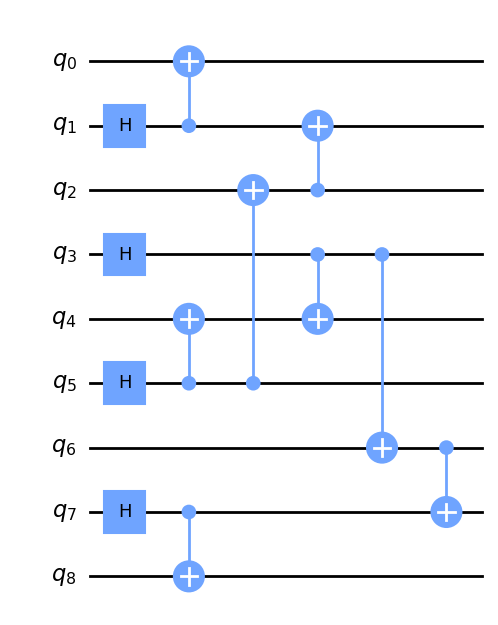

In [18]:
qc = rot_surf_code(1)
qc.draw("mpl", style="clifford")

In [28]:
def logical_operators(qc: QuantumCircuit, hadamard = False) -> Operator:                          #Gibt mir X_L und Z_L als Observablen raus, damit ich deren Eigenwert bestimmen kann für den GESAMTEN Circuit
    size = qc.num_qubits
    n = int(size/9)
    string_x = ""
    string_z = ""
    if hadamard:
        for i in range(n):
            string_x += "IIIXXXIII"
            string_z += "IZIIZIIZI"
    else:
        for i in range(n):
            string_x += "IXIIXIIXI"
            string_z += "IIIZZZIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def logical_operators_first_qubit(qc: QuantumCircuit, hadamard = False) -> Operator:              #Gibt mir X_L und Z_L nur für den ersten logical qubit!!!
    string_x = "IIIIIIIII"
    string_z = "IIIIIIIII"
    size = qc.num_qubits
    n = int(size/9)
    if hadamard:
        for i in range(n-2):
            string_x = "IIIIIIIII"
            string_z = "IIIIIIIII"
        string_x += "IIIXXXIII"
        string_z += "IZIIZIIZI"
    else:
        for i in range(n-2):
            string_x = "IIIIIIIII"
            string_z = "IIIIIIIII"
        string_x += "IXIIXIIXI"
        string_z += "IIIZZZIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def estimate_observables(circuit: QuantumCircuit, observables: list):
    estimator = StatevectorEstimator()
    pub = (circuit, observables)
    job = estimator.run([pub])
    result = job.result()[0]
    return result

def X_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    elif type(n) == list:
        for i in n:
            circuit.x(9*i+1)
            circuit.x(9*i+4)
            circuit.x(9*i+7)
    return circuit

def Z_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    elif type(n) == list:
        for i in n:
            circuit.z(9*i+3)
            circuit.z(9*i+4)
            circuit.z(9*i+5)
    return circuit

def Hadmard(circuit: QuantumCircuit, n=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    if type(n) == int:
        for i in range(9):
            circuit.h(9*n+i)
    return circuit

def X_L_rot(circuit: QuantumCircuit, n=0):            #X_L nach einem H-Gate
    if type(n) == int:
        circuit.x(9*n+3)
        circuit.x(9*n+4)
        circuit.x(9*n+5)
    elif type(n) == list:
        for i in n:
            circuit.x(9*i+3)
            circuit.x(9*i+4)
            circuit.x(9*i+5)
    return circuit

def Z_L_rot(circuit: QuantumCircuit, n=0):            #Z_L nach einem H-Gate
    if type(n) == int:
        circuit.z(9*n+1)
        circuit.z(9*n+4)
        circuit.z(9*n+7)
    elif type(n) == list:
        for i in n:
            circuit.z(9*i+1)
            circuit.z(9*i+4)
            circuit.z(9*i+7)
    return circuit

def CNOT(circuit:QuantumCircuit, control: int):               #ich programmiers jetzt mal nur für den Spezialfall von 2 Circuits
    n = int(circuit.num_qubits/2)            # = 9   ofc
    if control == 0:
        for i in range(n):
            circuit.cx(i,9+i)
    else:
        for i in range(n):
            circuit.cx(9+i,i)
    return circuit

def logical_S(circuit: QuantumCircuit, n=0):
    for i in range(9):
        circuit.z(9*n+i)
        circuit.s(9*n+i)
    return circuit

def log_T_Gate(circuit: QuantumCircuit, hadamard: False):           #Für den Spezialfall mit zwei logischen Quibts (0_L und phi_L=1_L) und einem ancilla qubits --> 19 total physical qubits
    ancilla = circuit.num_qubits
    circuit.H(ancilla)
    circuit.TGate(ancilla)
    if hadamard:
        Z_times_x = "IIIIIIIII"
        Z_times_x += "IIIZZZIII"
    else:
        Z_times_x = "IIIIIIIII"
        Z_times_x += "IZIIZIIZI"
    logical_Z_times_X = SparsePauliOp.from_list([(Z_times_x,1.0)])
    result = estimate_observables(circuit, [logical_Z_times_X])
    if result.data.evs[0] == -1:
        circuit = logical_S(circuit, 1)
    ancilla_x_meas = SparsePauliOp.from_list([("IIIIIIIIIIIIIIIIIIX",1.0)])
    result = estimate_observables(circuit, [ancilla_x_meas])
    if result.data.evs[0] == -1:
        circuit = Z_L(circuit, 1)
    return circuit
    
def log_controlled_S(circuit: QuantumCircuit, k: int, control: int, target: int) -> QuantumCircuit:
    k = 2
    


In [27]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc)

qc = X_L(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])
#result.data.stds
# for idx, pauli in enumerate([x_l,z_l]):
#     plt.plot(result.data.evs[idx], label=pauli)
# plt.legend()

Erwartungswert von X_L :  0.0
Erwartungswert von Z_L :  -0.9999999999999992


In [21]:
qc = rot_surf_code(2)

x_l, z_l = logical_operators_first_qubit(qc)

#qc = X_L(qc)

qc = X_L(qc,1)

qc = CNOT(qc,1)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L vom ersten log. Qubit : ",result.data.evs[0])
print("Erwartungswert von Z_L vom ersten log. Qubit : ",result.data.evs[1])

Erwartungswert von X_L vom ersten log. Qubit :  0.0
Erwartungswert von Z_L vom ersten log. Qubit :  -0.9999999999999998


In [22]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc, True)

qc = Hadmard(qc)


# for j in range(101):
#     for i in range(qc.num_qubits):
#         qc.h(i)

qc = Z_L_rot(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])

Erwartungswert von X_L :  -0.9999999999999981
Erwartungswert von Z_L :  0.0
